In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


SCROLL TO THE LAST CELLBLOCK! The first part is just the separate stuff. 


The first block of code identifies "control" and "calibrator" testids that are the same. 

In [2]:
import pandas as pd

# Read the data
df = pd.read_csv('1.1seconddataset.csv')

# Filter rows where 'sampletypename' is either 'control' or 'calibrator'
df_filtered = df[df['sampletypename'].isin(['Control', 'Calibrator'])]

# Group by 'testid' and get the count of each test ID
sample_groups = df_filtered.groupby('testid').size()

# Filter to only include test IDs that appear more than once (same test ID in multiple rows)
duplicate_sample_groups = sample_groups[sample_groups > 1]

# Print out the test IDs that have duplicates along with their counts
print("Test IDs that appear more than once (with 'control' or 'calibrator' sample type):")
print(duplicate_sample_groups)





Test IDs that appear more than once (with 'control' or 'calibrator' sample type):
testid
311322      2
311323      2
311324      2
311325      2
311326      2
           ..
11994793    2
11994794    2
11994795    2
11994796    2
11994800    2
Length: 426, dtype: int64


This block compares calibrator data. I ensured that they were from the same reagent lot 

In [3]:
import pandas as pd

# Read the data
df = pd.read_csv('1.1seconddataset.csv')

# Check column names to ensure correct naming
print("Columns in the dataset:", df.columns)

# Filter rows where 'sampletypename' is 'Calibrator' (omit 'Control')
df = df[df['sampletypename'] == 'Calibrator']

# Group by both 'testid' and 'assaynumber' to calculate the max and min of 'correctedcount' for each group, keeping the reagentmasterlotnumber as well
test_groups = df.groupby(['testid', 'assaynumber']).agg(
    min_value=('correctedcount', 'min'),
    max_value=('correctedcount', 'max'),
    min_lot=('reagentmasterlotnumber', 'first'),  # Get the reagentmasterlotnumber for the minimum value
    max_lot=('reagentmasterlotnumber', 'first')   # Get the reagentmasterlotnumber for the maximum value
)

# Filter out the test groups where the min value is 0, 1, or less than 1000 to avoid infinite or trivial percent differences
test_groups = test_groups[(test_groups['min_value'] != 0) & (test_groups['min_value'] != 1) & (test_groups['min_value'] > 1000)]

# Calculate the percent difference between max and min values for each testid and assaynumber combination
test_groups['percent_difference'] = ((test_groups['max_value'] - test_groups['min_value']) / test_groups['min_value']) * 100

# Filter out rows where the percent difference is 0 or greater than 100
test_groups = test_groups[(test_groups['percent_difference'] != 0)]

# Sort the test groups by the highest percent difference
sorted_test_groups = test_groups.sort_values(by='percent_difference', ascending=False)

# Show the test groups with the largest percent difference (excluding min values of 0 or 1, percent difference == 0, percent difference > 1000, and only 'calibrator' sample types)
print("Test groups with the largest percent difference (excluding min values of 0 or 1, percent difference == 0, percent difference > 1000, and 'calibrator' sample types):")
print(sorted_test_groups[['percent_difference', 'min_lot', 'max_lot']])


Columns in the dataset: Index(['datetimestamplocal', 'moduleserialnumber', 'assaynumber',
       'sampletypename', 'testid', 'correctedcount', 'reagentmasterlotnumber',
       'controllotnumber', 'SID'],
      dtype='object')
Test groups with the largest percent difference (excluding min values of 0 or 1, percent difference == 0, percent difference > 1000, and 'calibrator' sample types):
Empty DataFrame
Columns: [percent_difference, min_lot, max_lot]
Index: []


This block compares control data. I am a little confused though because I was under the impression that these controls were tested one after the other. But some of the repeating ones are tested on different dates? I don't know if we should compare them. This is JUST FOR THE first data set though. This may be different for the big one. 

In [4]:
import pandas as pd

# Read the data
df = pd.read_csv('1.1seconddataset.csv')

# Check column names to ensure correct naming
print("Columns in the dataset:", df.columns)

# Filter rows where 'sampletypename' is 'Control' (omit 'Calibrator')
df = df[df['sampletypename'] == 'Control']

# Group by both 'testid' and 'assaynumber' and calculate the max and min of 'correctedcount' for each group
test_groups = df.groupby(['testid', 'assaynumber'])['correctedcount'].agg(['max', 'min'])

# Filter out the test groups where the min value is 0, 1, or less than 1000 to avoid infinite or trivial percent differences
test_groups = test_groups[(test_groups['min'] != 0) & (test_groups['min'] != 1) & (test_groups['min'] > 1000)]

# Calculate the percent difference between max and min values for each testid and assaynumber combination
test_groups['percent_difference'] = ((test_groups['max'] - test_groups['min']) / test_groups['min']) * 100

# Filter out rows where the percent difference is 0 or greater than 100
test_groups = test_groups[(test_groups['percent_difference'] != 0) ]

# Sort the test groups by the highest percent difference
sorted_test_groups = test_groups.sort_values(by='percent_difference', ascending=False)

# Show the test groups with the largest percent difference (excluding min values of 0 or 1, percent difference == 0, percent difference > 1000, and only 'control' sample types)
print("Test groups with the largest percent difference (excluding min values of 0 or 1, percent difference == 0, percent difference > 1000, and 'control' sample types):")
print(sorted_test_groups[['percent_difference']])


Columns in the dataset: Index(['datetimestamplocal', 'moduleserialnumber', 'assaynumber',
       'sampletypename', 'testid', 'correctedcount', 'reagentmasterlotnumber',
       'controllotnumber', 'SID'],
      dtype='object')
Test groups with the largest percent difference (excluding min values of 0 or 1, percent difference == 0, percent difference > 1000, and 'control' sample types):
                      percent_difference
testid   assaynumber                    
4973794  468                62939.916260
11994781 248                 1593.553932
5646875  468                  964.596707
11994792 248                  451.462441
4973793  468                  356.213018
5646874  468                   15.893588


This plots only control data

/var/folders/_1/7hwrd93x58sfzq0d8jbx4qcr0000gn/T/ipykernel_53230/3165598411.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['datetimestamplocal'] = pd.to_datetime(df_filtered['datetimestamplocal'], format='%m/%d/%Y %H:%M', errors='coerce')
/var/folders/_1/7hwrd93x58sfzq0d8jbx4qcr0000gn/T/ipykernel_53230/3165598411.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['datetimestamplocal'] = pd.to_datetime(df_filtered['datetimestamplocal'], format='%m/%d/%Y %H:%M', errors='coerce'

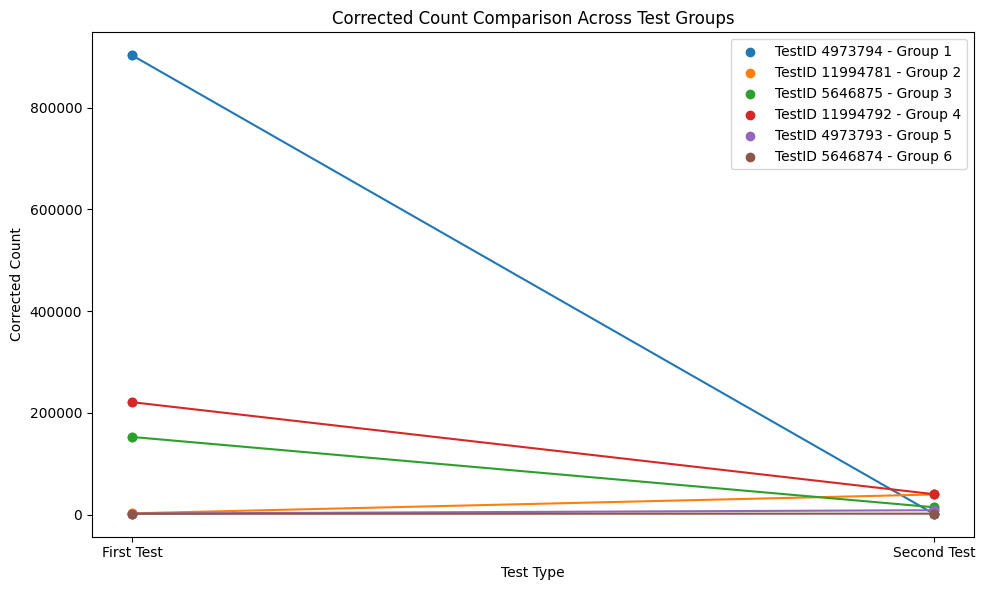

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('1.1seconddataset.csv')

# Strip any leading/trailing whitespace from the 'testid' column to avoid mismatches
df['testid'] = df['testid'].astype(str).str.strip()

# Function to filter and plot test data
def plot_test_data(testid, label):
    df_filtered = df[df['testid'] == testid]

    if len(df_filtered) != 2:
        print(f"Error: There are not exactly two tests for testid '{testid}'. Found {len(df_filtered)} tests.")
    else:
        # Ensure 'datetimestamplocal' is in datetime format for proper sorting
        df_filtered['datetimestamplocal'] = pd.to_datetime(df_filtered['datetimestamplocal'], format='%m/%d/%Y %H:%M', errors='coerce')

        # Drop rows where 'datetimestamplocal' or 'correctedcount' are NaT or NaN
        df_filtered = df_filtered.dropna(subset=['datetimestamplocal', 'correctedcount'])

        # Ensure 'correctedcount' is numeric
        df_filtered['correctedcount'] = pd.to_numeric(df_filtered['correctedcount'], errors='coerce')

        # Drop rows where 'correctedcount' is NaN
        df_filtered = df_filtered.dropna(subset=['correctedcount'])

        if len(df_filtered) == 2:
            # Sort by 'datetimestamplocal' to identify the first and second test
            df_filtered = df_filtered.sort_values(by='datetimestamplocal')

            # Add a column to label the tests as "First Test" and "Second Test"
            df_filtered['test_type'] = ['First Test', 'Second Test']

            # Extract the relevant columns for plotting
            df_plot = df_filtered[['test_type', 'correctedcount']]

            # Plot the data points (scatter)
            plt.scatter(df_plot['test_type'], df_plot['correctedcount'], label=f'TestID {testid} - {label}')

            # Connect the points with a line
            plt.plot(df_plot['test_type'], df_plot['correctedcount'], linestyle='-', marker='o')

# List of test IDs you want to plot (copy and paste your list of test IDs here)
test_ids_to_plot = [
    '4973794', '11994781', '5646875', '11994792', '4973793', '5646874'
]

# Plot data for all test IDs in the list
plt.figure(figsize=(10, 6))

# Loop over each test ID and plot it
for idx, testid in enumerate(test_ids_to_plot):
    plot_test_data(testid, f'Group {idx+1}')  # You can customize the label format as needed

# Customize the plot
plt.title('Corrected Count Comparison Across Test Groups')
plt.xlabel('Test Type')
plt.ylabel('Corrected Count')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()







USE THIS CELL BELOW


Test IDs that appear more than once (with 'calibrator' sample type):
testid
663840    2
663841    2
663842    2
663843    2
663844    2
663845    2
663846    2
663847    2
663848    2
663849    2
663850    2
663851    2
664046    2
664047    2
dtype: int64

Test IDs that appear more than once (with 'control' sample type):
testid
11994776    2
11994777    2
11994778    2
11994779    2
11994780    2
           ..
877438      2
877441      2
877442      2
877443      2
877444      2
Length: 91, dtype: int64

Test groups with the largest percent difference ('control' sample types):
                      percent_difference
testid   assaynumber                    
4973794  468                62939.916260
11994781 248                 1593.553932
5646875  468                  964.596707
11994792 248                  451.462441
4973793  468                  356.213018
5646874  468                   15.893588

Test IDs: '4973794', '11994781', '4973793', '11994792', '5646875', '5646874'


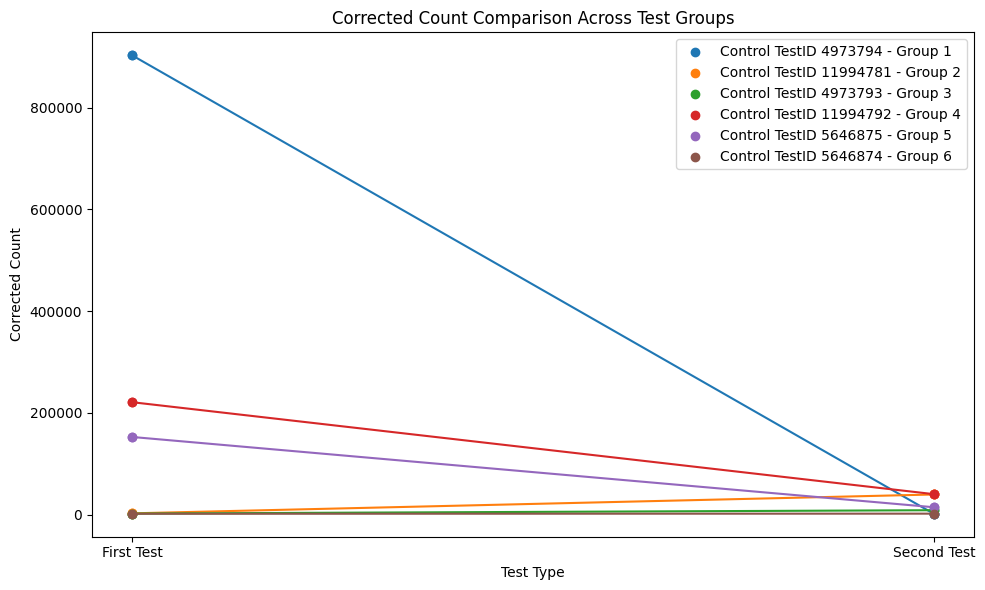

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('1.1seconddataset.csv')

# Strip any leading/trailing whitespace from 'testid' to avoid mismatches
df['testid'] = df['testid'].astype(str).str.strip()

# ---- Part 1: Filtering and Counting Test IDs ----
# Drop rows where 'correctedcount' is NaN
df = df.dropna(subset=['correctedcount'])

# Filter rows for 'Control' and 'Calibrator' separately
df_calibrator = df[df['sampletypename'] == 'Calibrator']
df_control = df[df['sampletypename'] == 'Control']

# Group by 'testid' and get the count of each test ID for calibrators
sample_groups_calibrator = df_calibrator.groupby('testid').size()

# Group by 'testid' and get the count of each test ID for controls
sample_groups_control = df_control.groupby('testid').size()

# Filter to only include test IDs that appear more than once for calibrators
duplicate_sample_groups_calibrator = sample_groups_calibrator[sample_groups_calibrator > 1]

# Filter to only include test IDs that appear more than once for controls
duplicate_sample_groups_control = sample_groups_control[sample_groups_control > 1]

# Print out the test IDs that have duplicates for calibrators
if not duplicate_sample_groups_calibrator.empty:
    print("\nTest IDs that appear more than once (with 'calibrator' sample type):")
    print(duplicate_sample_groups_calibrator)

# Print out the test IDs that have duplicates for controls
if not duplicate_sample_groups_control.empty:
    print("\nTest IDs that appear more than once (with 'control' sample type):")
    print(duplicate_sample_groups_control)


# ---- Part 2: Percent Difference for Calibrator Samples ----
# Filter rows where 'sampletypename' is 'Calibrator'
df_calibrator = df[df['sampletypename'] == 'Calibrator']

# Group by both 'testid' and 'assaynumber' and calculate the max and min of 'correctedcount' for each group
test_groups_calibrator = df_calibrator.groupby(['testid', 'assaynumber']).agg(
    min_value=('correctedcount', 'min'),
    max_value=('correctedcount', 'max'),
    min_lot=('reagentmasterlotnumber', 'first'),
    max_lot=('reagentmasterlotnumber', 'first')
)

# Filter out the test groups where the min value is 0, 1, or less than 1000 to avoid infinite or trivial percent differences
test_groups_calibrator = test_groups_calibrator[
    (test_groups_calibrator['min_value'] != 0) & 
    (test_groups_calibrator['min_value'] != 1) & 
    (test_groups_calibrator['min_value'] > 1000)
]

# Calculate the percent difference between max and min values for each testid and assaynumber combination
test_groups_calibrator['percent_difference'] = ((test_groups_calibrator['max_value'] - test_groups_calibrator['min_value']) / test_groups_calibrator['min_value']) * 100

# Filter out rows where the percent difference is 0
test_groups_calibrator = test_groups_calibrator[test_groups_calibrator['percent_difference'] != 0]

# Sort the test groups by the highest percent difference
sorted_test_groups_calibrator = test_groups_calibrator.sort_values(by='percent_difference', ascending=False)

# Print the test groups with the largest percent difference (excluding trivial cases)
if not sorted_test_groups_calibrator.empty:
    print("\nTest groups with the largest percent difference ('calibrator' sample types):")
    print(sorted_test_groups_calibrator[['percent_difference', 'min_lot', 'max_lot']])


# ---- Part 3: Percent Difference for Control Samples ----
# Filter rows where 'sampletypename' is 'Control'
df_control = df[df['sampletypename'] == 'Control']

# Group by both 'testid' and 'assaynumber' and calculate the max and min of 'correctedcount' for each group
test_groups_control = df_control.groupby(['testid', 'assaynumber'])['correctedcount'].agg(['max', 'min'])

# Filter out the test groups where the min value is 0, 1, or less than 1000
test_groups_control = test_groups_control[
    (test_groups_control['min'] != 0) & 
    (test_groups_control['min'] != 1) & 
    (test_groups_control['min'] > 1000)
]

# Calculate the percent difference between max and min values for each testid and assaynumber combination
test_groups_control['percent_difference'] = ((test_groups_control['max'] - test_groups_control['min']) / test_groups_control['min']) * 100

# Filter out rows where the percent difference is 0
test_groups_control = test_groups_control[test_groups_control['percent_difference'] != 0]

# Sort the test groups by the highest percent difference
sorted_test_groups_control = test_groups_control.sort_values(by='percent_difference', ascending=False)

# Print the test groups with the largest percent difference ('control' sample types)
if not sorted_test_groups_control.empty:
    print("\nTest groups with the largest percent difference ('control' sample types):")
    print(sorted_test_groups_control[['percent_difference']])


# ---- Part 4: Plotting Data

# List of test IDs you want to plot (from both calibrator and control test groups)
test_ids_to_plot_calibrator = sorted_test_groups_calibrator.index.get_level_values('testid').unique()
test_ids_to_plot_control = sorted_test_groups_control.index.get_level_values('testid').unique()

# Combine both lists of test IDs (calibrator and control)
test_ids_to_plot = set(test_ids_to_plot_calibrator).union(test_ids_to_plot_control)

# Print the list of test IDs in the desired format
test_ids_str = "', '".join(list(test_ids_to_plot))  # Convert set to list first
print(f"\nTest IDs: '{test_ids_str}'")

# Function to filter and plot test data
def plot_test_data(testid, label, sample_type):
    df_filtered = df[df['testid'] == testid]
    df_filtered = df_filtered[df_filtered['sampletypename'] == sample_type]

    if len(df_filtered) != 2:
        print(f"Error: There are not exactly two tests for testid '{testid}'. Found {len(df_filtered)} tests.")
    else:
        # Ensure 'datetimestamplocal' is in datetime format for proper sorting
        df_filtered['datetimestamplocal'] = pd.to_datetime(df_filtered['datetimestamplocal'], format='%m/%d/%Y %H:%M', errors='coerce')

        # Drop rows where 'datetimestamplocal' or 'correctedcount' are NaT or NaN
        df_filtered = df_filtered.dropna(subset=['datetimestamplocal', 'correctedcount'])

        # Ensure 'correctedcount' is numeric
        df_filtered['correctedcount'] = pd.to_numeric(df_filtered['correctedcount'], errors='coerce')

        # Drop rows where 'correctedcount' is NaN
        df_filtered = df_filtered.dropna(subset=['correctedcount'])

        if len(df_filtered) == 2:
            # Sort by 'datetimestamplocal' to identify the first and second test
            df_filtered = df_filtered.sort_values(by='datetimestamplocal')

            # Add a column to label the tests as "First Test" and "Second Test"
            df_filtered['test_type'] = ['First Test', 'Second Test']

            # Extract the relevant columns for plotting
            df_plot = df_filtered[['test_type', 'correctedcount']]

            # Plot the data points (scatter)
            plt.scatter(df_plot['test_type'], df_plot['correctedcount'], label=f'{sample_type} TestID {testid} - {label}')

            # Connect the points with a line
            plt.plot(df_plot['test_type'], df_plot['correctedcount'], linestyle='-', marker='o')

# Plot data for all test IDs in the list (calibrators and controls)
plt.figure(figsize=(10, 6))

# Loop over each test ID and plot it for both 'Calibrator' and 'Control'
for idx, testid in enumerate(test_ids_to_plot):
    # Plot for calibrator only
    if testid in test_ids_to_plot_calibrator:
        plot_test_data(testid, f'Group {idx+1}', sample_type='Calibrator')
    # Plot for control only
    if testid in test_ids_to_plot_control:
        plot_test_data(testid, f'Group {idx+1}', sample_type='Control')

# Customize the plot
plt.title('Corrected Count Comparison Across Test Groups')
plt.xlabel('Test Type')
plt.ylabel('Corrected Count')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



